# Set Up

## Importing Libraries

In [244]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Extra

# Data Collection/Preprocessing

## Collecting Data

In [245]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [246]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/1.jpeg,0,0,1,0,0
1,outputs/training_data/vertically_flipped_1.jpeg,0,0,1,0,0
2,outputs/training_data/horizontally_flipped_1.jpeg,0,0,1,0,0
3,outputs/training_data/2.jpeg,0,0,1,0,0
4,outputs/training_data/vertically_flipped_2.jpeg,0,0,1,0,0


## Analyzing Data

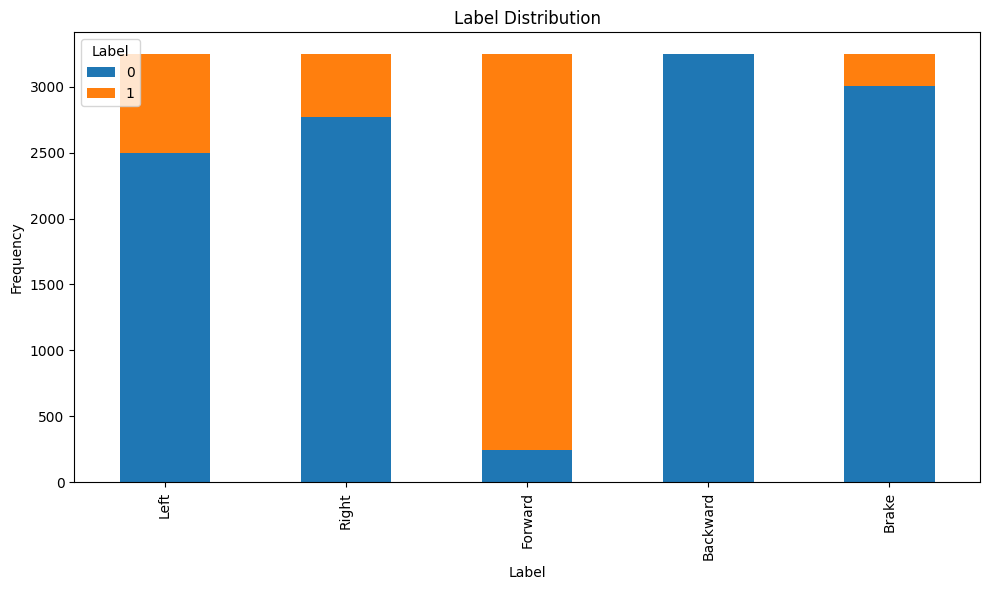

In [247]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [248]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [249]:
data['path'][0]

'outputs/training_data/1.jpeg'

In [250]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [251]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [252]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [253]:
sample_image_path = "../outputs/training_data/1.jpeg"
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
num_channels = len(sample_image.getbands())

# Neural Network

## Model Set Up

In [254]:
optimizer = Adam(learning_rate=0.001)

In [255]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
        image_height, image_width, num_channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.Flatten(),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.6),
    layers.Dense(4, activation='sigmoid')
])

In [256]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 21, 21, 64)        36928     
                                                                 
 flatten_11 (Flatten)        (None, 28224)           

## Training Model

In [257]:
model.compile(optimizer=optimizer, loss='mse')

In [258]:
history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_val, y_val))

Epoch 1/25
82/82 [==============================] - 6s 65ms/step - loss: 0.3336 - val_loss: 0.3607
Epoch 2/25
82/82 [==============================] - 5s 64ms/step - loss: 0.2507 - val_loss: 0.1546
Epoch 3/25
82/82 [==============================] - 5s 64ms/step - loss: 0.2486 - val_loss: 0.1558
Epoch 4/25
82/82 [==============================] - 5s 64ms/step - loss: 0.3056 - val_loss: 0.2861
Epoch 5/25
82/82 [==============================] - 5s 64ms/step - loss: 0.3099 - val_loss: 0.2854
Epoch 6/25
82/82 [==============================] - 5s 65ms/step - loss: 0.2994 - val_loss: 0.2845
Epoch 7/25
82/82 [==============================] - 5s 64ms/step - loss: 0.2848 - val_loss: 0.2841
Epoch 8/25
82/82 [==============================] - 5s 64ms/step - loss: 0.2771 - val_loss: 0.1547
Epoch 9/25
82/82 [==============================] - 5s 64ms/step - loss: 0.2854 - val_loss: 0.1545
Epoch 10/25
82/82 [==============================] - 5s 65ms/step - loss: 0.2875 - val_loss: 0.1541
Epoch 11/

## Testing Model

In [259]:
test_loss = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 14ms/step - loss: 0.1565


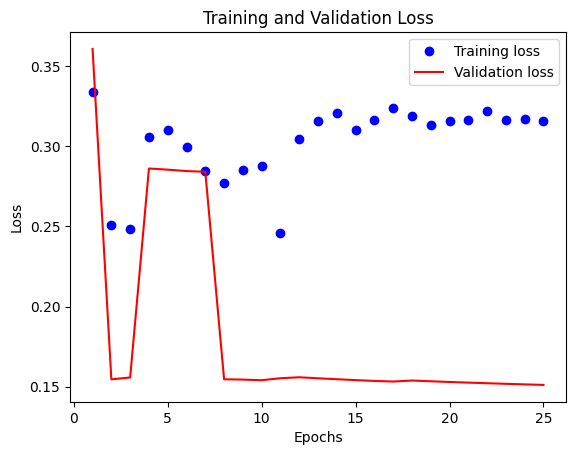

In [260]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

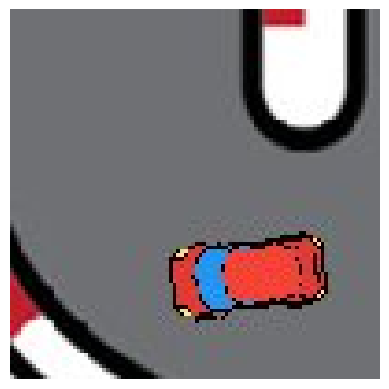

In [261]:
image = X_test[8]
plt.imshow(image)
plt.axis('off')
plt.show()

In [262]:
test_image = image.reshape(1, image_height, image_width, num_channels)

In [263]:
predictions = model.predict(test_image)

1/1 [==============================] - 0s 71ms/step


In [264]:
print(predictions)

[[0. 0. 1. 0.]]


## Prediction Distribution

In [265]:
predictions_list = []
for num in range(100):
    image = X_test[num]
    test_image = image.reshape(1, image_height, image_width, num_channels)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 18ms/step


In [266]:
predictions_list

[array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32),
 array([[0.

## Saving Model Weights

In [267]:
model.save("../models/CNN_steering_model.h5")

c:\Users\andyx\Desktop\Projects\SelfDrivingCarSimulator\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
